# Performing ordinal encoding based on the target value

To do this, first, we must calculate the mean value of the target per category. Next, we must order the categories from the one with the lowest to the one with the highest target mean value. Finally, we must assign digits to the ordered categories, starting with 0 to the first category up to k-1 to the last category, where k is the number of distinct categories

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv("processing_data.csv")

X_train,X_test,Y_train,Y_test = train_test_split(data.drop("target",axis=1),data["target"],test_size=0.1,random_state=23)



In [3]:
#we using twp columns and groupby to mean values
Y_train.groupby(X_train["A7"]).mean().sort_values()

A7
ff         0.153846
dd         0.200000
v          0.403846
bb         0.411765
Missing    0.428571
j          0.428571
n          0.500000
o          0.500000
h          0.631148
z          0.714286
Name: target, dtype: float64

In [4]:
#seeing the indexs category_names
ordered_labels = Y_train.groupby(X_train["A7"]).mean().sort_values().index

In [5]:
ordered_labels

Index(['ff', 'dd', 'v', 'bb', 'Missing', 'j', 'n', 'o', 'h', 'z'], dtype='object', name='A7')

In [6]:
#dictinoary of category-to-integer pairs 
ordinal_mapping = {k:i for i,k in enumerate(ordered_labels,0)}

ordinal_mapping

{'ff': 0,
 'dd': 1,
 'v': 2,
 'bb': 3,
 'Missing': 4,
 'j': 5,
 'n': 6,
 'o': 7,
 'h': 8,
 'z': 9}

In [7]:
#replace the categories in A7 in the train and test sets
X_train["A7_enc"] = X_train["A7"].map(ordinal_mapping)

X_test["A7_enc"] = X_test["A7"].map(ordinal_mapping)

To better understand the monotonic relationship concept, let’s plot the relationship of the categories of the A7 variable with the target before and after the encoding

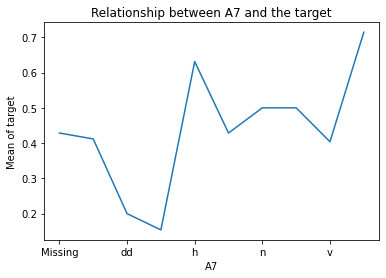

In [8]:
Y_train.groupby(X_train["A7"]).mean().plot()

plt.title("Relationship between A7 and the target")

plt.ylabel("Mean of target")

plt.show()

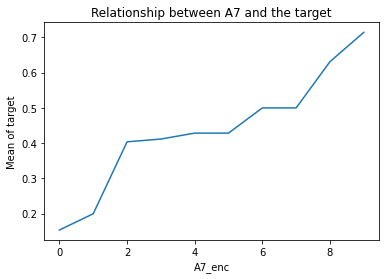

In [9]:
Y_train.groupby(X_train["A7_enc"]).mean().plot()

plt.title("Relationship between A7 and the target")

plt.ylabel("Mean of target")

plt.show()

The encoded variable shows a monotonic relationship with the target – the higher the mean target value, the higher the digit assigned to the category

In the given scenario, the ordinal encoding is performed based on the mean target value of each category. The higher the mean target value for a category, the higher the encoded value assigned to that category. This implies that categories with higher mean target values are assigned higher ordinal values, while categories with lower mean target values are assigned lower ordinal values.

For example, if we have a target variable that represents the probability of customer churn, and we perform ordinal encoding based on the mean churn rate for each category, the encoded values will reflect the likelihood of churn. Categories with higher encoded values would indicate a higher churn rate, while categories with lower encoded values would indicate a lower churn rate

In [10]:
#using feature_engine
from feature_engine.encoding import OrdinalEncoder

ordinal_enc = OrdinalEncoder(encoding_method="ordered",variables=None)

ordinal_enc.fit(X_train, Y_train)

X_train_enc = ordinal_enc.transform(X_train)

X_test_enc = ordinal_enc.transform(X_test)

X_train_enc

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A7_enc
222,1,17.58,9.000,1,1,5,2,1.375,1,0,0,1,1,0.0,0,2
281,2,23.92,0.585,0,0,13,8,0.125,0,0,0,0,1,240.0,1,8
557,1,32.17,1.460,1,1,9,2,1.085,1,1,16,0,1,120.0,2079,2
679,1,20.08,1.250,1,1,7,2,0.000,0,0,0,0,1,0.0,0,2
366,1,22.75,6.165,1,1,5,2,0.165,0,0,0,0,1,220.0,1000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2,21.33,7.500,1,1,5,2,1.415,1,1,1,0,1,80.0,9800,2
31,2,42.00,9.790,1,1,14,8,7.960,1,1,8,0,1,0.0,0,8
488,2,18.83,3.540,0,0,0,0,0.000,0,0,0,1,1,180.0,1,0
40,2,34.17,9.170,1,1,7,2,4.500,1,1,12,1,1,0.0,221,2


# Implementing target mean encoding

In its simplest form, the numerical representation for each category is given by the mean value of the target variable for a particular category group. For example, if we have a City variable, with the categories of London, Manchester, and Bristol, and we want to predict the default rate (the target takes values 0 and 1); if the default rate for London is 30%, we replace London with 0.3; if the default rate for Manchester is 20%, we replace Manchester with 0.2; and so on. If the target is continuous – say we want to predict income – then we would replace London, Manchester, and Bristol with the mean income earned in each city

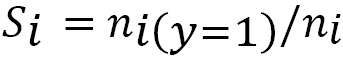

Here, the numerator is the number of observations with a target value of 1 for category i and the denominator is the number of observations with a category value of i.

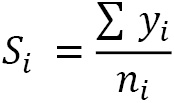


Here, the numerator is the sum of the target across observations in category i and ni is the total number of observations in category i.

These formulas provide a good approximation of the target estimate if there is a sufficiently large number of observations with each category value – in other words, if ni is large. However, in most datasets, categorical variables will only have categorical values present in a few observations. In these cases, target estimates derived from the precedent formulas can be unreliable.


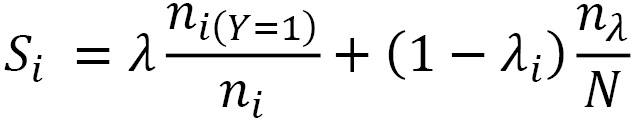

To mitigate poor estimates returned for rare categories, the target estimates can be determined as a mixture of two probabilities: those returned by the preceding formulas and the prior probability of the target based on the entire training set. The two probabilities are blended using a weighting factor, which is a function of the category group size

In this formula, ny is the total number of cases where the target takes a value of 1, N is the size of the train set, and 𝛌 is the weighting factor

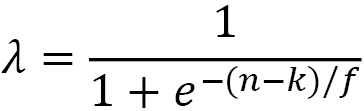

Here, k is half of the minimal size for which we fully trust the first term of the equation. The f parameter is selected by the user either arbitrarily or with optimization

In [11]:
mapping = Y_train.groupby(X_train["A7"]).mean().to_dict()

X_train["A7"] = X_train["A7"].map(mapping)

X_test["A7"] = X_test["A7"].map(mapping)

In [12]:
#using feature-engine 
from feature_engine.encoding import MeanEncoder

mean_enc = MeanEncoder(variables=None)


mean_enc.fit(X_train,Y_train)
print( mean_enc.encoder_dict_)
X_train_enc = mean_enc.transform(X_train)

X_test_enc = mean_enc.transform(X_test)

X_train_enc

{'A1': {'Missing': 0.2727272727272727, 'a': 0.4340659340659341, 'b': 0.43457943925233644}, 'A4': {'Missing': 0.6, 'l': 1.0, 'u': 0.4817204301075269, 'y': 0.26174496644295303}, 'A5': {'Missing': 0.6, 'g': 0.4817204301075269, 'gg': 1.0, 'p': 0.26174496644295303}, 'A6': {'Missing': 0.42857142857142855, 'aa': 0.3469387755102041, 'c': 0.4180327868852459, 'cc': 0.7297297297297297, 'd': 0.20689655172413793, 'e': 0.5217391304347826, 'ff': 0.14583333333333334, 'i': 0.23076923076923078, 'j': 0.3333333333333333, 'k': 0.2765957446808511, 'm': 0.4166666666666667, 'q': 0.6197183098591549, 'r': 0.6666666666666666, 'w': 0.5178571428571429, 'x': 0.84375}, 'A9': {'f': 0.0728476821192053, 't': 0.7711598746081505}, 'A10': {'f': 0.2541436464088398, 't': 0.6795366795366795}, 'A12': {'f': 0.4174174174174174, 't': 0.4479166666666667}, 'A13': {'g': 0.4450354609929078, 'p': 0.5714285714285714, 's': 0.26}}


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A7_enc
222,0.434066,17.58,9.000,0.481720,0.481720,0.346939,0.403846,1.375,0.771160,0.254144,0,0.447917,0.445035,0.0,0,2
281,0.434579,23.92,0.585,0.261745,0.261745,0.729730,0.631148,0.125,0.072848,0.254144,0,0.417417,0.445035,240.0,1,8
557,0.434066,32.17,1.460,0.481720,0.481720,0.517857,0.403846,1.085,0.771160,0.679537,16,0.417417,0.445035,120.0,2079,2
679,0.434066,20.08,1.250,0.481720,0.481720,0.418033,0.403846,0.000,0.072848,0.254144,0,0.417417,0.445035,0.0,0,2
366,0.434066,22.75,6.165,0.481720,0.481720,0.346939,0.403846,0.165,0.072848,0.254144,0,0.417417,0.445035,220.0,1000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,0.434579,21.33,7.500,0.481720,0.481720,0.346939,0.403846,1.415,0.771160,0.679537,1,0.417417,0.445035,80.0,9800,2
31,0.434579,42.00,9.790,0.481720,0.481720,0.843750,0.631148,7.960,0.771160,0.679537,8,0.417417,0.445035,0.0,0,8
488,0.434579,18.83,3.540,0.261745,0.261745,0.145833,0.153846,0.000,0.072848,0.254144,0,0.447917,0.445035,180.0,1,0
40,0.434579,34.17,9.170,0.481720,0.481720,0.418033,0.403846,4.500,0.771160,0.679537,12,0.447917,0.445035,0.0,221,2


cols: This parameter specifies the columns (categorical variables) to encode. If set to None, it indicates that all categorical variables in the dataset should be encoded. You can provide a list of column names if you only want to encode specific variables.

min_samples_leaf: This parameter determines the minimum number of samples required in each category of the categorical variable to calculate the target mean. Categories with fewer samples than this threshold will be encoded with a default value (usually the overall mean of the target variable) instead of the category-specific mean. It helps to handle categories with limited data or potential noise.

smoothing: This parameter controls the smoothing effect applied to the target mean encoding. Smoothing is used to balance the impact of the category-specific mean and the overall mean of the target variable. A higher value of smoothing reduces the influence of the category-specific mean and increases the impact of the overall mean. Smoothing helps to mitigate the risk of overfitting and reduces the impact of rare categories or categories with limited data

In [13]:
#using taragetEndocrt 
from category_encoders.target_encoder import TargetEncoder

mean_enc = TargetEncoder(cols=None, min_samples_leaf=25,smoothing=1.0)


mean_enc.fit(X_train, Y_train)

X_train_enc = mean_enc.transform(X_train)

X_test_enc = mean_enc.transform(X_test)

By using y_train, the encoder can determine the mean of the target variable for each category in the categorical variables. This information is crucial for generating the mapping between categories and their target mean values, which will later be used to encode the categorical variables

In [14]:
X_train_enc = mean_enc.transform(X_train)

X_test_enc = mean_enc.transform(X_test)


X_train_enc

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A7_enc
222,0.434066,17.58,9.000,0.481720,0.481720,0.346939,0.403846,1.375,0.771160,0.254144,0,0.447917,0.445035,0.0,0,2
281,0.434579,23.92,0.585,0.261745,0.261745,0.729728,0.631148,0.125,0.072848,0.254144,0,0.417417,0.445035,240.0,1,8
557,0.434066,32.17,1.460,0.481720,0.481720,0.517857,0.403846,1.085,0.771160,0.679537,16,0.417417,0.445035,120.0,2079,2
679,0.434066,20.08,1.250,0.481720,0.481720,0.418033,0.403846,0.000,0.072848,0.254144,0,0.417417,0.445035,0.0,0,2
366,0.434066,22.75,6.165,0.481720,0.481720,0.346939,0.403846,0.165,0.072848,0.254144,0,0.417417,0.445035,220.0,1000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,0.434579,21.33,7.500,0.481720,0.481720,0.346939,0.403846,1.415,0.771160,0.679537,1,0.417417,0.445035,80.0,9800,2
31,0.434579,42.00,9.790,0.481720,0.481720,0.843374,0.631148,7.960,0.771160,0.679537,8,0.417417,0.445035,0.0,0,8
488,0.434579,18.83,3.540,0.261745,0.261745,0.145833,0.153846,0.000,0.072848,0.254144,0,0.447917,0.445035,180.0,1,0
40,0.434579,34.17,9.170,0.481720,0.481720,0.418033,0.403846,4.500,0.771160,0.679537,12,0.447917,0.445035,0.0,221,2


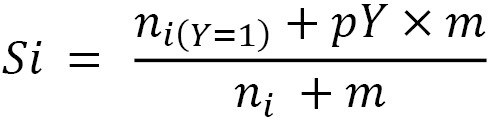

There’s more… 
There is an alternative way to return better target estimates when the category groups are small. 

Here, ni(Y=1) is the target mean for category i and ni is the number of observations with category i. The target prior is given by pY and m is the weighting factor. With this adjustment, the only parameter that we have to set is the weight, m. If m is large, then more importance is given to the target’s prior probability. This adjustment affects target estimates for all categories but mostly for those with fewer observations because, in such cases, m could be much larger than ni in the formula’s denominator

In [15]:
from category_encoders.m_estimate import MEstimateEncoder

encoder = MEstimateEncoder(cols=['A4'], m=5)
X_train_encoded = encoder.fit_transform(X_train, Y_train)
X_test_encoded = encoder.transform(X_test)

X_test_encoded

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A7_enc
197,b,48.17,7.625,0.481187,g,w,0.631148,15.500,t,t,12,f,g,0.0,790,8
185,b,48.75,8.500,0.481187,g,c,0.631148,12.500,t,t,9,f,g,181.0,1655,8
394,b,41.17,1.250,0.267259,p,w,0.403846,0.250,f,f,0,f,g,0.0,195,2
274,b,30.67,2.500,0.481187,g,cc,0.631148,2.250,f,f,0,t,s,340.0,0,8
73,b,44.25,0.500,0.481187,g,m,0.403846,10.750,t,f,0,f,s,400.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,b,25.75,0.500,0.481187,g,c,0.403846,1.460,t,t,5,t,g,312.0,0,2
580,b,31.67,0.830,0.481187,g,x,0.403846,1.335,t,t,8,t,g,303.0,3290,2
463,a,36.58,0.290,0.481187,g,ff,0.153846,0.000,f,t,10,f,g,200.0,18,0
196,b,33.17,3.165,0.267259,p,x,0.403846,3.165,t,t,3,t,g,380.0,0,2


Encoding with the Weight of Evidence

The Weight of Evidence (WoE) was developed primarily for credit and financial industries to facilitate variable screening and exploratory analysis and to build more predictive linear models to evaluate the risk of loan defaults

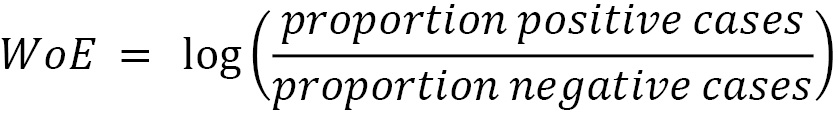


WoE = 0 if p(positive) / p(negative) = 1; that is, if the outcome is random
WoE > 0 if p(positive) > p(negative)
WoE < 0 if p(negative) > p(positive)

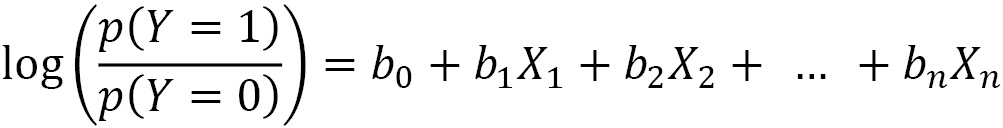

Logistic regression models a binary response, Y, based on X predictor variables, assuming that there is a linear relationship between X and the log of odds of Y.

Here, log (p(Y=1)/p(Y=0)) is the log of odds. As you can see, the WoE encodes the categories in the same scale – that is, the log of odds – as the outcome of the logistic regression

In [16]:
#Let’s get the inverse of the target values to be able to calculate the negative cases
neg_y_train = pd.Series(np.where(Y_train == 1, 0, 1),index=Y_train.index)

neg_y_train.head(10)

222    0
281    1
557    0
679    1
366    1
664    1
351    1
251    0
369    1
571    0
dtype: int64

In [17]:
#Let’s determine the number of observations where the target variable takes a value of 1 or 0
total_pos = Y_train.sum()

total_neg = neg_y_train.sum()

total_pos/total_pos

1.0

In [18]:
pos = Y_train.groupby(X_train["A1"]).sum() / total_pos

neg = neg_y_train.groupby(X_train["A1"]).sum() / total_neg

#let’s calculate the WoE per category
woe = np.log(pos/neg)

woe.head()

A1
Missing   -0.705348
a          0.010200
b          0.012290
dtype: float64

In [19]:
X_train["A1"] = X_train["A1"].map(woe)

X_test["A1"] = X_test["A1"].map(woe)

X_train["A1"]

222    0.01020
281    0.01229
557    0.01020
679    0.01020
366    0.01020
        ...   
237    0.01229
31     0.01229
488    0.01229
40     0.01229
595    0.01229
Name: A1, Length: 621, dtype: float64

In [20]:
from feature_engine.encoding import WoEEncoder
X_train,X_test,Y_train,Y_test = train_test_split(data.drop("target",axis=1),data["target"],test_size=0.1,random_state=23)

woe_enc = WoEEncoder(variables = ["A1", "A9", "A12"])

woe_enc.fit(X_train, Y_train)

X_train_enc = woe_enc.transform(X_train)

X_test_enc = woe_enc.transform(X_test)

X_train_enc

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
222,0.01020,17.58,9.000,u,g,aa,v,1.375,1.490353,f,0,0.066389,g,0.0,0
281,0.01229,23.92,0.585,y,p,cc,h,0.125,-2.268266,f,0,-0.057903,g,240.0,1
557,0.01020,32.17,1.460,u,g,w,v,1.085,1.490353,t,16,-0.057903,g,120.0,2079
679,0.01020,20.08,1.250,u,g,c,v,0.000,-2.268266,f,0,-0.057903,g,0.0,0
366,0.01020,22.75,6.165,u,g,aa,v,0.165,-2.268266,f,0,-0.057903,g,220.0,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,0.01229,21.33,7.500,u,g,aa,v,1.415,1.490353,t,1,-0.057903,g,80.0,9800
31,0.01229,42.00,9.790,u,g,x,h,7.960,1.490353,t,8,-0.057903,g,0.0,0
488,0.01229,18.83,3.540,y,p,ff,ff,0.000,-2.268266,f,0,0.066389,g,180.0,1
40,0.01229,34.17,9.170,u,g,c,v,4.500,1.490353,t,12,0.066389,g,0.0,221


# Grouping rare or infrequent categories

Rare categories are those present only in a small fraction of the observations. There is no rule of thumb to determine how small a small fraction is, but typically, any value below 5% can be considered rare

In [31]:
# capture the fraction of observations per category in A7 in a variable
from feature_engine.encoding import RareLabelEncoder

freqs = X_train["A7"].value_counts(normalize=True)

freqs

# create a list containing the names of the categories present in more than 5% of the observations

frequent_cat = [x for x in freqs.loc[freqs > 0.05].index.values]

#replace rare labels – that is, those present in <= 5% of the observations – with the "Rare" string

X_train["A7"] = np.where(X_train["A7"].isin(frequent_cat),X_train["A7"], "Rare")

X_test["A7"] = np.where(X_test["A7"].isin(frequent_cat),X_test["A7"], "Rare")

SyntaxError: invalid syntax (2103158271.py, line 14)

In [33]:
X_train["A7"].value_counts(normalize=True)

v       0.586151
h       0.196457
ff      0.083736
bb      0.082126
Rare    0.051530
Name: A7, dtype: float64

In [36]:

#using feature_engine

X_train,X_test,Y_train,Y_test = train_test_split(data.drop("target",axis=1),data["target"],test_size=0.1,random_state=23)


rare_encoder = RareLabelEncoder(tol=0.05, n_categories=4)

rare_encoder.fit(X_train)

X_train_enc = rare_encoder.transform(X_train)

X_test_enc = rare_encoder.transform(X_test)

/home/parrot/.local/lib/python3.9/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable A1 is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/home/parrot/.local/lib/python3.9/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable A4 is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/home/parrot/.local/lib/python3.9/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable A5 is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/home/parrot/.local/lib/python3.9/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable A9 is less than that indicated in n_categories. Thus, all cate

In [39]:
X_train_enc["A7"].value_counts(normalize=True)

v       0.586151
h       0.196457
ff      0.083736
bb      0.082126
Rare    0.051530
Name: A7, dtype: float64

# Performing binary encoding

Binary encoding is a categorical encoding technique that uses binary code – that is, a sequence of zeroes and ones – to represent the different categories of the variable. How does it work? First, the categories are arbitrarily replaced with ordinal numbers, as shown in the intermediate step of the following table. Then, those numbers are converted into binary code. For example, integer 1 can be represented as sequence 10, integer 2 as 01, integer 3 as 11, and integer 0 as 00

In [43]:
from category_encoders.binary import BinaryEncoder

X_train,X_test,Y_train,Y_test = train_test_split(data.drop("target",axis=1),data["target"],test_size=0.1,random_state=23)

X_train["A7"].unique()

#create a binary encoder to encode A7
encoder = BinaryEncoder(cols=["A7"], drop_invariant=True)

encoder.fit(X_train)

BinaryEncoder(cols=['A7'], drop_invariant=True,
              mapping=[{'col': 'A7',
                        'mapping':      A7_0  A7_1  A7_2  A7_3
 1      0     0     0     1
 2      0     0     1     0
 3      0     0     1     1
 4      0     1     0     0
 5      0     1     0     1
 6      0     1     1     0
 7      0     1     1     1
 8      1     0     0     0
 9      1     0     0     1
 10     1     0     1     0
-1      0     0     0     0
-2      0     0     0     0}])

In [46]:
X_train_enc = encoder.transform(X_train)

X_test_enc = encoder.transform(X_test)

X_train_enc

,A1,A2,A3,A4,A5,A6,A7_0,A7_1,A7_2,A7_3,A8,A9,A10,A11,A12,A13,A14,A15
222,a,17.58,9.000,u,g,aa,0,0,0,1,1.375,t,f,0,t,g,0.0,0
281,b,23.92,0.585,y,p,cc,0,0,1,0,0.125,f,f,0,f,g,240.0,1
557,a,32.17,1.460,u,g,w,0,0,0,1,1.085,t,t,16,f,g,120.0,2079
679,a,20.08,1.250,u,g,c,0,0,0,1,0.000,f,f,0,f,g,0.0,0
366,a,22.75,6.165,u,g,aa,0,0,0,1,0.165,f,f,0,f,g,220.0,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,b,21.33,7.500,u,g,aa,0,0,0,1,1.415,t,t,1,f,g,80.0,9800
31,b,42.00,9.790,u,g,x,0,0,1,0,7.960,t,t,8,f,g,0.0,0
488,b,18.83,3.540,y,p,ff,0,0,1,1,0.000,f,f,0,t,g,180.0,1
40,b,34.17,9.170,u,g,c,0,0,0,1,4.500,t,t,12,t,g,0.0,221
